In [ ]:
!unzip stable.zip

Archive:  stable.zip
 extracting: animSett.py             
 extracting: createVideo.py          
 extracting: environnew.py           
 extracting: keyFrame.py             
 extracting: loadModel.py            
 extracting: loadSetting.py          
 extracting: load_model.py           
 extracting: mainOld.py              
 extracting: prompts.py              
 extracting: spleeter.py             
 extracting: upscale.py              
 extracting: utils.py                
 extracting: whisperapi.py           


In [ ]:
import environnew

Setting up environment...

Environment set up in 195 seconds


In [ ]:
# Clone Real-ESRGAN and enter the Real-ESRGAN
!git clone -q https://github.com/xinntao/Real-ESRGAN.git
%cd Real-ESRGAN
# Set up the environment
!pip install basicsr -q
!pip install facexlib -q
!pip install gfpgan -q
!pip install -r requirements.txt -q
!python setup.py develop 
# Download the pre-trained model
!wget https://github.com/xinntao/Real-ESRGAN/releases/download/v0.1.0/RealESRGAN_x4plus.pth -P experiments/pretrained_models
%cd ..

/content/Real-ESRGAN
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.5/172.5 kB 11.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.5/298.5 kB 35.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 101.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.9/200.9 kB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 kB 308.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 18.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.2/52.2 kB 4.6 MB/s eta 0:00:00
/usr/local/lib/python3.9/dist-packages/setuptools/__init__.py:84: _DeprecatedInstaller: setuptools.installer and fetch_build_eggs are deprecated.
!!

        ********************************************************************************
        Requirements should be satisfied by a PEP 517 installer.
        If you are using pip

In [ ]:
!pip install fastapi nest-asyncio pyngrok uvicorn -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 784.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 681.2/681.2 kB 37.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.9/66.9 kB 9.1 MB/s eta 0:00:00


In [ ]:
!pip install python-multipart -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 4.0 MB/s eta 0:00:00


In [ ]:
from fastapi import FastAPI, Request, File, Form, BackgroundTasks
from fastapi.responses import FileResponse
from fastapi.middleware.cors import CORSMiddleware
import sys
import os
sys.path.extend([
    'src/taming-transformers',
    'src/clip',
    'stable-diffusion/',
    'k-diffusion',
    'pytorch3d-lite',
    'AdaBins',
    'MiDaS',
])
import load_model
import torch
from mainOld import musictoVid
import time
app = FastAPI()
origins = ["*"]
app.add_middleware(
    CORSMiddleware,
    allow_origins=origins,
    allow_credentials=True,
    allow_methods=["*"],
    allow_headers=["*"],
)

custom_checkpoint_path = '/content/drive/MyDrive/AI/models/dreamlikeDiffusion10_10.ckpt'
models_path = "/content/models" 
os.makedirs(models_path, exist_ok=True)
model = load_model.model(models_path,custom_checkpoint_path=custom_checkpoint_path)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = model.to(device)

tasks = {}

@app.get('/')
async def home():
  return {'mes':'as'}


def long_running_task(device, model, audio_path, theme, artist, option, upscale, task_id):
    # Do the long-running task here
    video_path = musictoVid(device, model, audio_path, theme, artist, int(option), upscale,task_id)
    tasks[task_id]['status'] = 'completed'
    tasks[task_id]['path'] = video_path

@app.post("/submit_form")
async def submit_form(background_tasks: BackgroundTasks,audio: bytes = File(...), artist: str = Form(''), theme: str = Form(''), option: str = Form(...), upscale: bool = Form(False)):
    # Save audio to current directory
    with open("audio.wav", "wb") as f:
        f.write(audio)
    
    # Print other form inputs
    print(f"Text input 1: {theme}")
    print(f"Text input 2: {artist}")
    print(f"Radio button: {option}")
    print(f"Checkbox: {upscale}")
    timestring = time.strftime('%Y%m%d%H%M%S')
    tasks[timestring] = {'status':'processing'}
    background_tasks.add_task(long_running_task, device, model, '/content/audio.wav', theme, artist, option, upscale, timestring)
    # return FileResponse(video_path)
    return {"id": timestring}

@app.post("/get_video/{task_id}")
async def get_video(task_id: str):
    # Retrieve the result of the task from the task dictionary using the task ID
    if task_id in tasks:
        task = tasks[task_id]
        status = task["status"]
        print('ABove')
        if status == "completed":
            print('jsjs')
            video_path = task["path"]
            print(video_path)
            filename = video_path.split('/')[-1]
            headers = {"Content-Disposition": f'attachment; filename="{filename}"'} 
            return FileResponse(video_path, headers=headers)
        else:
            return {"status": status}
    else:
        return {"error": "Task not found"}

Using config: ./stable-diffusion/configs/stable-diffusion/v1-inference.yaml
Using ckpt: /content/drive/MyDrive/AI/models/dreamlikeDiffusion10_10.ckpt
Loading model from /content/drive/MyDrive/AI/models/dreamlikeDiffusion10_10.ckpt
Global Step: None
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.9.layer_norm1.weight', 'vision_model.encoder.layers.18.self_attn.out_proj.bias', 'vision_model.post_layernorm.weight', 'vision_model.encoder.layers.22.mlp.fc1.weight', 'vision_model.encoder.layers.16.layer_norm1.bias', 'vision_model.encoder.layers.8.self_attn.q_proj.weight', 'vision_model.encoder.layers.17.self_attn.k_proj.bias', 'vision_model.encoder.layers.8.self_attn.k_proj.weight', 'vision_model.encoder.layers.11.layer_norm1.bias', 'vision_model.encoder.layers.6.mlp.fc2.weight', 'vision_model.encoder.layers.17.mlp.fc1.bias', 'vision_model.encoder.layers.11.mlp.fc1.weight', 'vision_model.encoder.layers.13.layer_norm2.bias', 'vision_model.encoder.layers.6.self_attn.q_proj.bias', 'vision_model.encoder.layers.19.self_attn.q_proj.weight', 'vision_model.encoder.layers.4.layer_norm2.bias', 'vision_model.encoder.layers.19.self_attn.q_proj.bias',

In [ ]:
!ngrok authtoken 2Oy4G6QRnRkrb0AomkVzibvTQmv_Qfd9mrNbPtRkygKjQtQ2

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


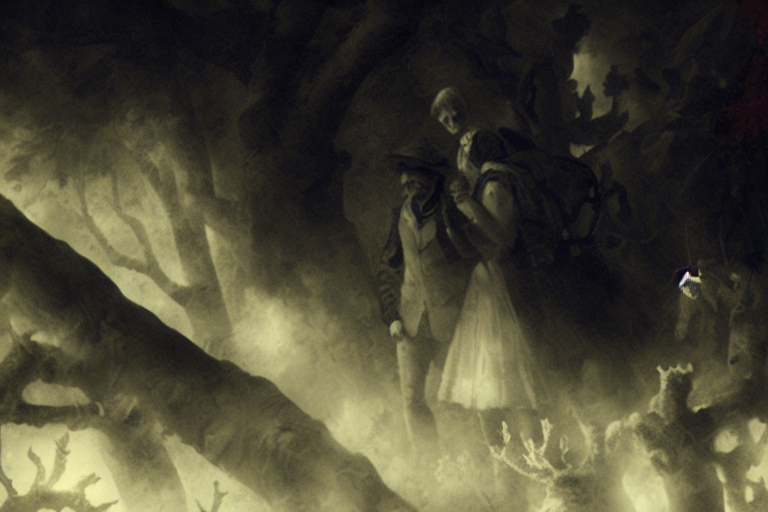

/content/output/20230427095022/StableFun/images/20230427094944_%05d.png  ->  /content/output/20230427095022/StableFun/20230427094944.mp4
ABove
jsjs
/content/output/20230427095022/StableFun/20230427094944.mp4
INFO:     117.219.22.193:0 - "POST /get_video/20230427094944 HTTP/1.1" 200 OK


INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [747]


In [ ]:
import nest_asyncio
from pyngrok import ngrok
import uvicorn

ngrok_tunnel = ngrok.connect(8000)
print('Public URL:', ngrok_tunnel.public_url)
nest_asyncio.apply()
uvicorn.run(app, port=8000, timeout_keep_alive=3600)